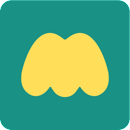

# Modak - data engineer challenge

## 1. Libs

In [4]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data loading

In [13]:
allowance_backend_table = pd.read_csv('data/allowance_backend_table.csv')
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
0,30f4e25e-3e37-462e-8c3c-42f24f54350f,1724838709,monthly,fifteenth_day,2024-10-15T08:00:41.445627563Z,15,enabled
1,6da398ad-079d-49b9-8668-6d7ce4d22683,1724659829,monthly,fifteenth_day,1724659829,15,enabled
2,2d30fe2d-6c32-4b8a-a19b-906184f64f62,1731309159,monthly,fifteenth_day,1731309159,15,enabled
3,c30180f3-b35c-470c-b25a-f12ec4ce3340,1725414982,monthly,first_day,2024-10-01T08:00:37.516552581Z,1,enabled
4,9f5768db-e953-4057-9fa5-264c46293fbd,1726267511,biweekly,friday,2024-10-02T02:33:10.97923183Z,11,disabled


In [14]:
payment_schedule_backend_table = pd.read_csv('data/payment_schedule_backend_table.csv')
payment_schedule_backend_table.head()

,user_id,payment_date
0,061d8039-b332-40ca-b906-3514b06411c2,22
1,0ca92d01-feed-42e5-b90c-299b615f9d3f,22
2,160bcd2d-3ab0-4a60-9bfa-ccfcc1ee17e4,22
3,1649fee7-c424-4fb7-ac84-db36e15e042a,22
4,1d647703-874d-4744-b4de-6a5212518aa8,22


In [12]:
with open('data/allowance_events.json') as f:
    allowance_events_json = json.load(f)
allowance_events = pd.json_normalize(allowance_events_json)
allowance_events.head()

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
0,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-21 1:39:34,allowance.created,weekly,sunday,10
1,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
2,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:28,allowance.created,biweekly,friday,10
4,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:37,allowance.edited,weekly,friday,10


In [15]:
allowance_backend_table['creation_date'] = pd.to_datetime(allowance_backend_table['creation_date'])

In [16]:
allowance_backend_table

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
0,30f4e25e-3e37-462e-8c3c-42f24f54350f,1970-01-01 00:00:01.724838709,monthly,fifteenth_day,2024-10-15T08:00:41.445627563Z,15,enabled
1,6da398ad-079d-49b9-8668-6d7ce4d22683,1970-01-01 00:00:01.724659829,monthly,fifteenth_day,1724659829,15,enabled
2,2d30fe2d-6c32-4b8a-a19b-906184f64f62,1970-01-01 00:00:01.731309159,monthly,fifteenth_day,1731309159,15,enabled
3,c30180f3-b35c-470c-b25a-f12ec4ce3340,1970-01-01 00:00:01.725414982,monthly,first_day,2024-10-01T08:00:37.516552581Z,1,enabled
4,9f5768db-e953-4057-9fa5-264c46293fbd,1970-01-01 00:00:01.726267511,biweekly,friday,2024-10-02T02:33:10.97923183Z,11,disabled
...,...,...,...,...,...,...,...
2877,2e26d7e7-b65e-4468-8096-5bed0ef99988,1970-01-01 00:00:01.729098435,biweekly,monday,2024-11-28T08:00:30.184784321Z,9,enabled
2878,adec35e8-3699-45e5-b675-4a6504b296de,1970-01-01 00:00:01.722370541,weekly,friday,2024-08-16T00:48:04.406999984Z,16,disabled
2879,e8505cf5-856d-4518-9cec-ffe4b72d9a45,1970-01-01 00:00:01.722370555,weekly,friday,2024-08-16T00:48:10.788978083Z,16,disabled
2880,e8f85eea-1974-4000-bde0-2ea7ade70f67,1970-01-01 00:00:01.729636767,biweekly,friday,1729636767,1,enabled
